In [5]:
# IMPORTS FROM LABS #
import sys 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from skimage.color import rgb2hsv, rgb2gray
from skimage.morphology import erosion, closing, opening, disk, remove_small_holes, remove_small_objects, binary_dilation
from skimage.transform import rotate, resize, warp
from sklearn.metrics.pairwise import euclidean_distances
from skimage.measure import regionprops, find_contours
from sklearn.cluster import KMeans
import numpy as np
import cv2 
import platform
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import Optional, Callable
from sklearn.metrics import accuracy_score, f1_score
from sklearn.covariance import LedoitWolf
import torch.optim as optim

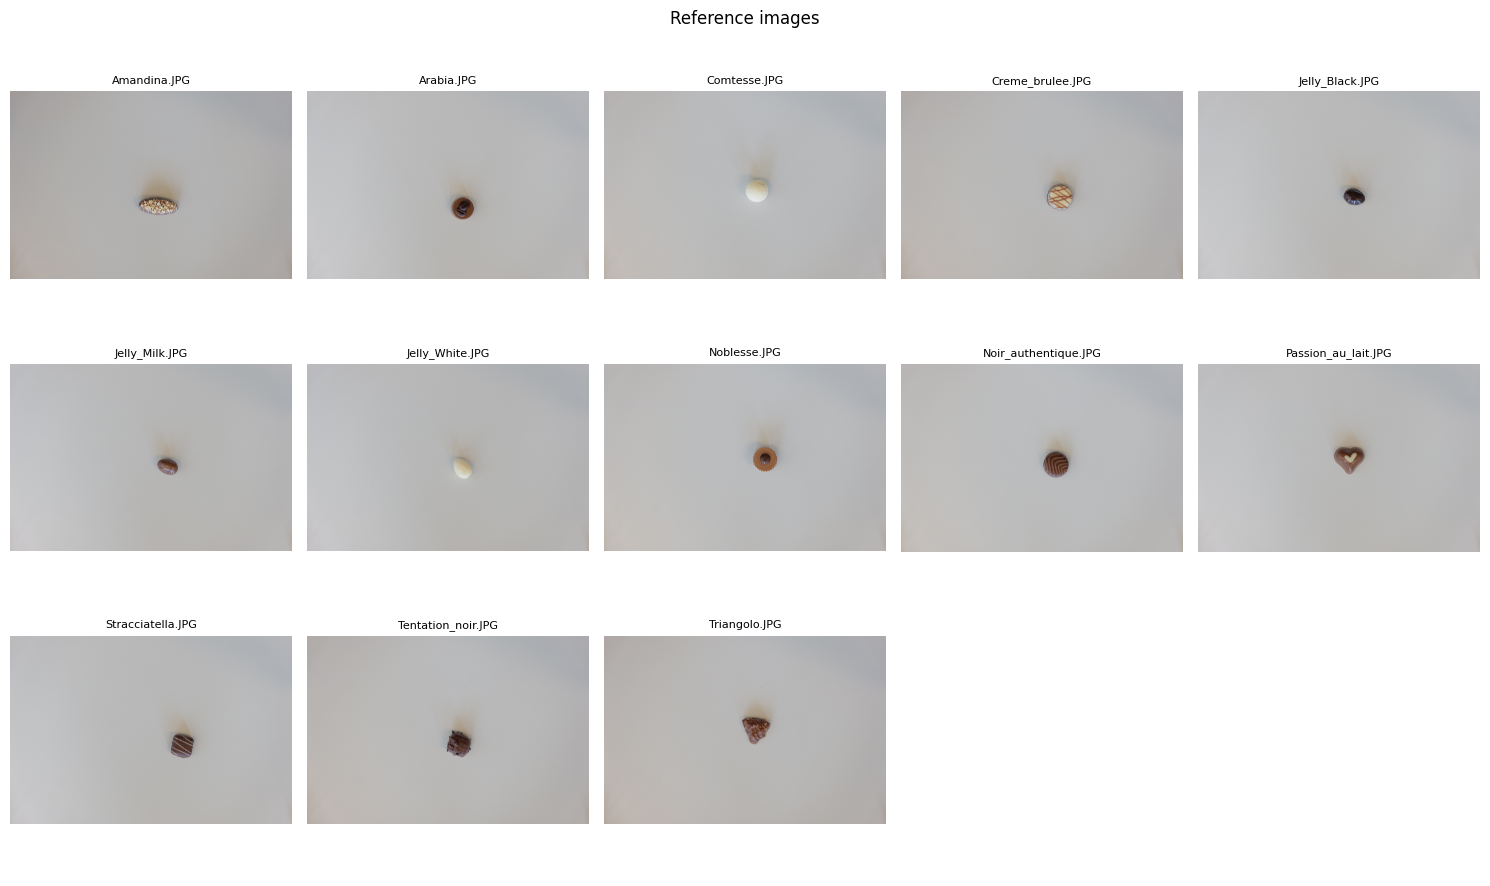

In [8]:
path_ref = 'dataset_project_iapr2025/references/'


jpg_files = [f for f in os.listdir(path_ref)]
n_images = len(jpg_files)

# Define grid size (square-ish)
cols = 5
rows = (n_images + cols - 1) // cols  # Round up division

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

plt.suptitle('Reference images')
reference_images = []
for i, ax in enumerate(axes):
    if i < n_images:
        img_path = os.path.join(path_ref, jpg_files[i])
        img = mpimg.imread(img_path)
        reference_images.append(img)
        ax.imshow(img)
        ax.set_title(jpg_files[i], fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()

In [ ]:
def segmentation(img):
    # --- 1. Load and Resize Image ---
    img = cv2.resize(img, (1600,1067))

    # --- 2. Convert to Grayscale ---
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # --- 3. Blur to Reduce Noise ---
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # --- 4. Canny Edge Detection ---
    edges = cv2.Canny(blurred, threshold1=20, threshold2=50)

    # --- 5. Dilate to Connect Broken Edges ---
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    dilated = cv2.dilate(edges, kernel, iterations=1)

    # --- 6. Morphological Closing to Fill Gaps ---
    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel, iterations=2)

    # --- 7. Remove Small Objects by Area Filtering ---
    # Find all contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # --- 7. Replace small contour filtering with ellipse fitting ---
    mask = np.zeros_like(closed)

    if contours:
        cnt = max(contours, key=cv2.contourArea)
    else:
        return

    area = cv2.contourArea(cnt)
    # Skip tiny noise
    if area < 2000:
        if len(cnt) >= 5:
            ellipse = cv2.fitEllipse(cnt)
            (x, y), (MA, ma), angle = ellipse
            if MA > 5 and ma > 5:
                cv2.ellipse(mask, ellipse, 255, -1)
    else:
        # If not enough points, fall back to filled contour
        cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)

    # --- 8. Get the mean color of chocolate ---
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV_FULL)
    chocolate_pixels_rgb = img[mask == 255]
    chocolate_pixels_hsv = hsv[mask == 255]

    h_channel = chocolate_pixels_hsv[:, 0]
    s_channel = chocolate_pixels_hsv[:, 1]
    v_channel = chocolate_pixels_hsv[:, 2]

    r_channel = chocolate_pixels_rgb[:, 0]
    g_channel = chocolate_pixels_rgb[:, 1]
    b_channel = chocolate_pixels_rgb[:, 2]

    mean_h = np.mean(h_channel)
    mean_s = np.mean(s_channel)
    mean_v = np.mean(v_channel)

    mean_r = np.mean(r_channel)
    mean_g = np.mean(g_channel)
    mean_b = np.mean(b_channel)

    mean_color_hsv = (mean_h, mean_s, mean_v)
    mean_color_rgb = (mean_r, mean_g, mean_b)

    # --- 9. Apply Mask to Original Image ---
    segmented_objects = cv2.bitwise_and(img, img, mask=mask)

    x, y, w, h = cv2.boundingRect(cnt)
    h = h + 30 
    w = w + 30

    # Crop each object from the original image
    chocolate_crop = segmented_objects[y-30:y+h, x-30:x+w]

    return chocolate_crop, mean_color_rgb

def plot_choc(img, mean_color):
    plt.figure()
    plt.imshow(img)
    plt.title(f"Chocolate (Mean Color: {mean_color})")
    plt.axis('off')
    plt.show()

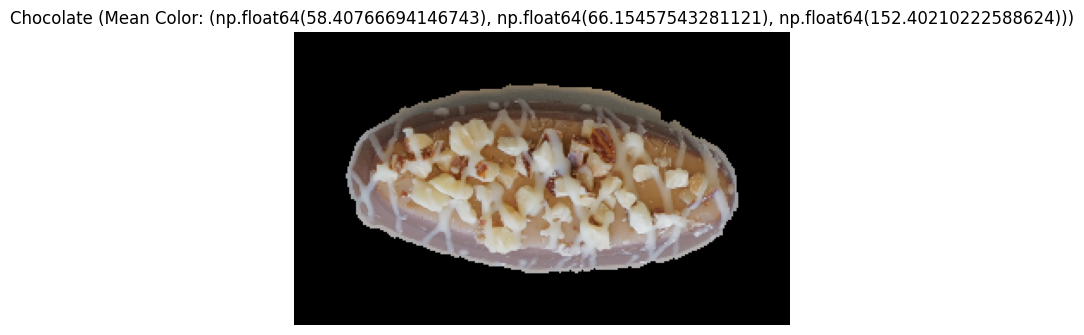

(np.float64(58.40766694146743), np.float64(66.15457543281121), np.float64(152.40210222588624))


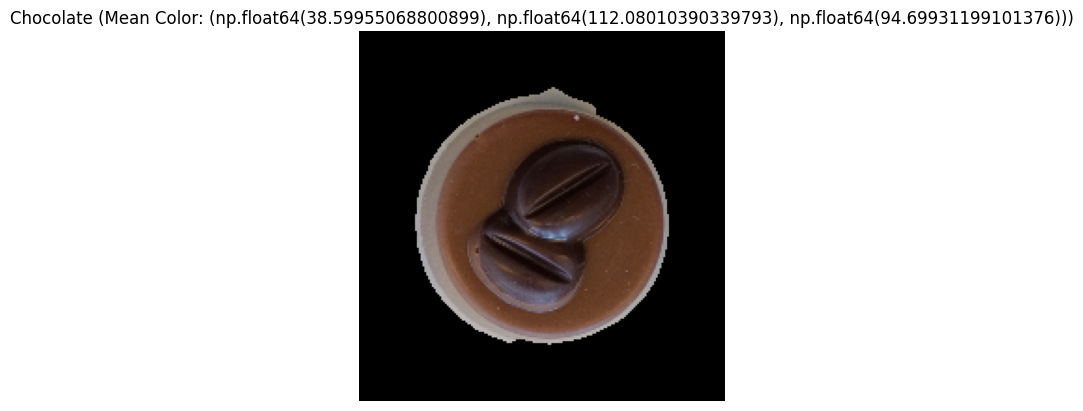

(np.float64(38.59955068800899), np.float64(112.08010390339793), np.float64(94.69931199101376))


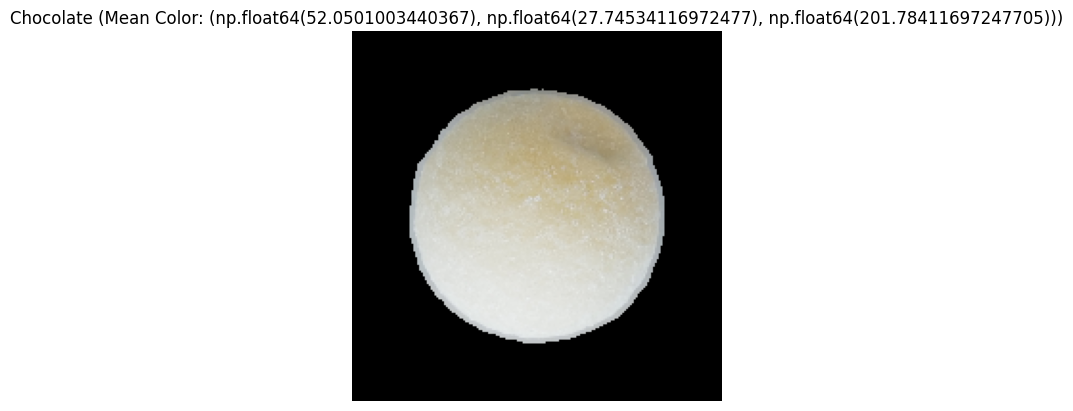

(np.float64(52.0501003440367), np.float64(27.74534116972477), np.float64(201.78411697247705))


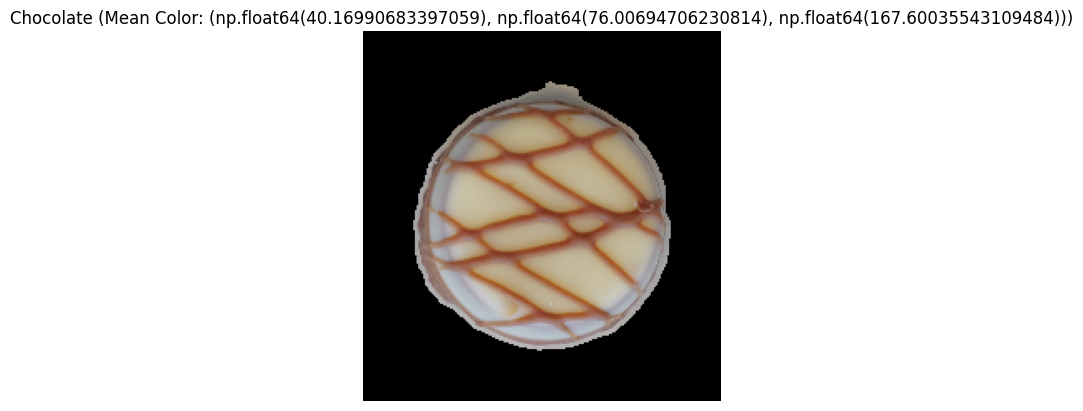

(np.float64(40.16990683397059), np.float64(76.00694706230814), np.float64(167.60035543109484))


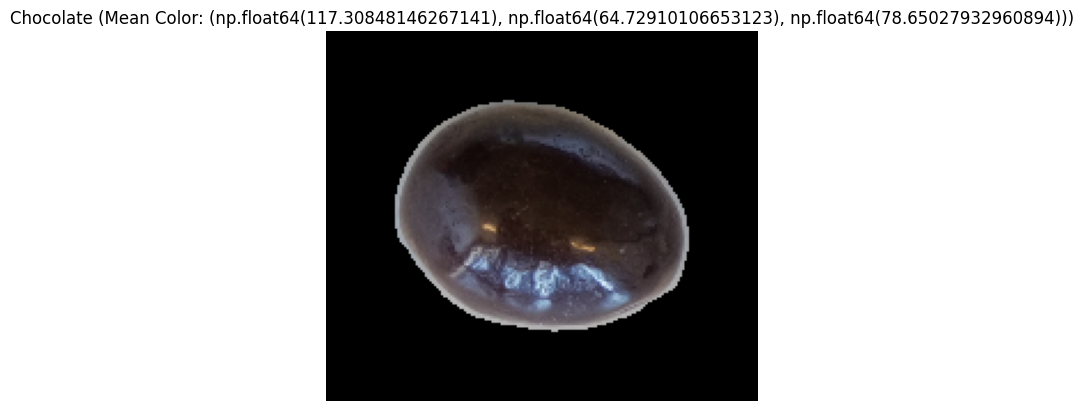

(np.float64(117.30848146267141), np.float64(64.72910106653123), np.float64(78.65027932960894))


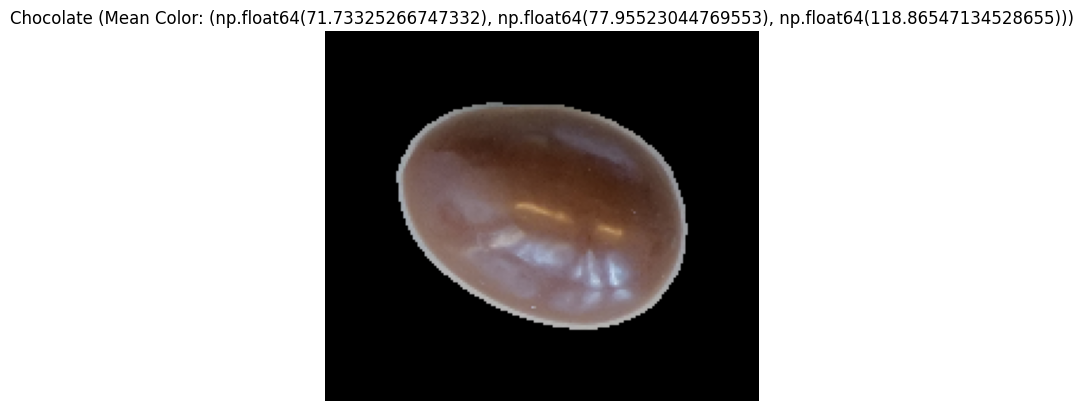

(np.float64(71.73325266747332), np.float64(77.95523044769553), np.float64(118.86547134528655))


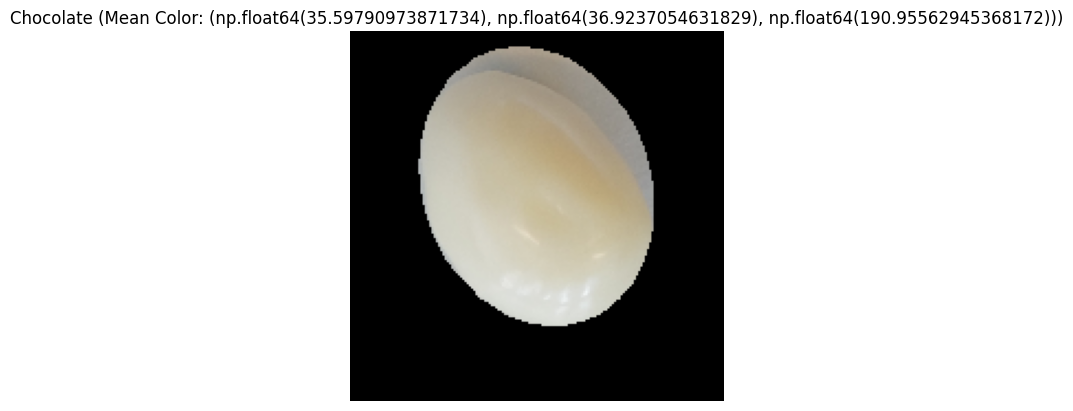

(np.float64(35.59790973871734), np.float64(36.9237054631829), np.float64(190.95562945368172))


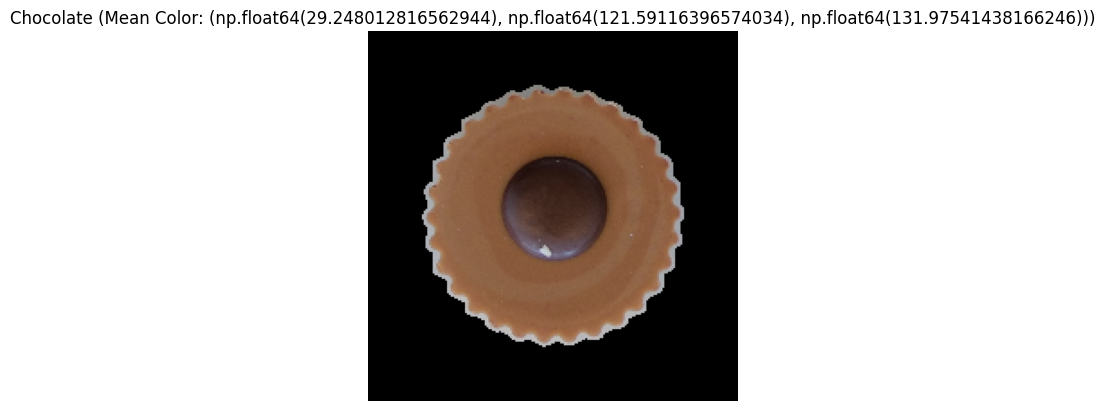

(np.float64(29.248012816562944), np.float64(121.59116396574034), np.float64(131.97541438166246))


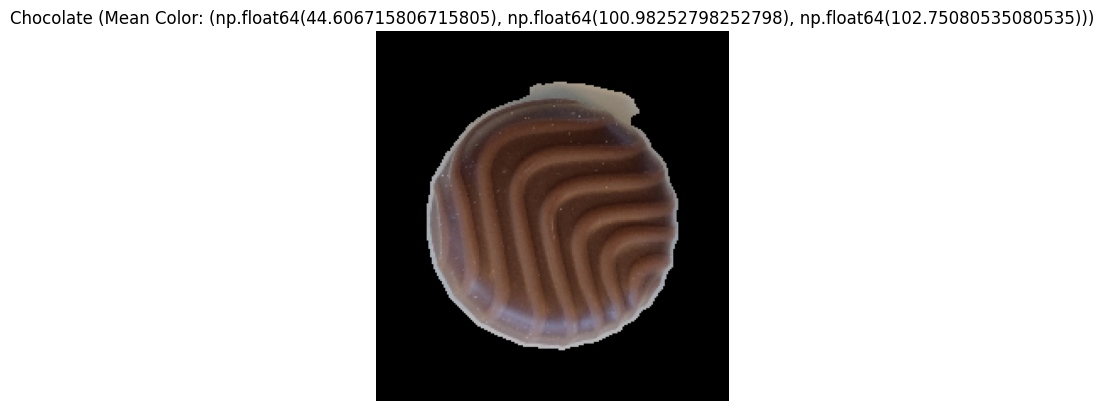

(np.float64(44.606715806715805), np.float64(100.98252798252798), np.float64(102.75080535080535))


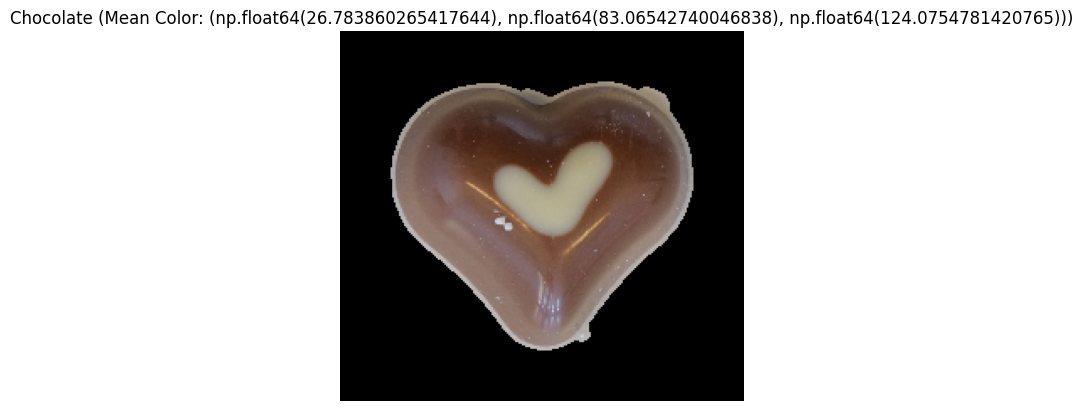

(np.float64(26.783860265417644), np.float64(83.06542740046838), np.float64(124.0754781420765))


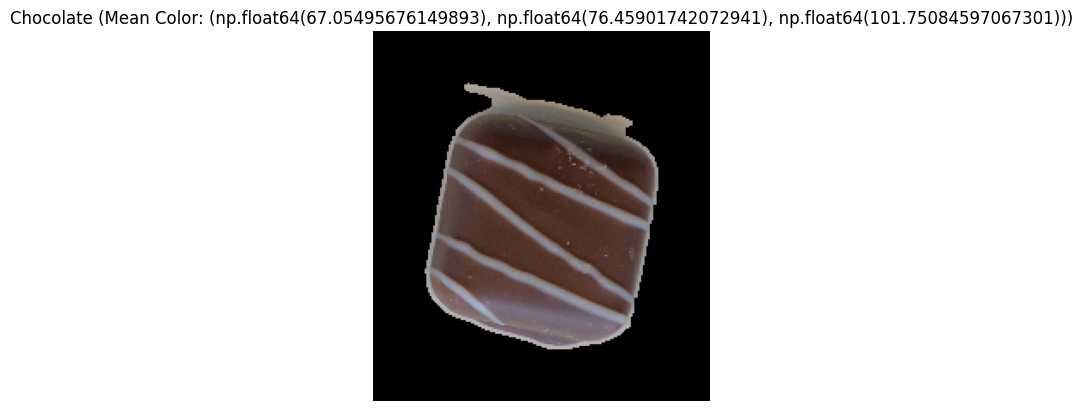

(np.float64(67.05495676149893), np.float64(76.45901742072941), np.float64(101.75084597067301))


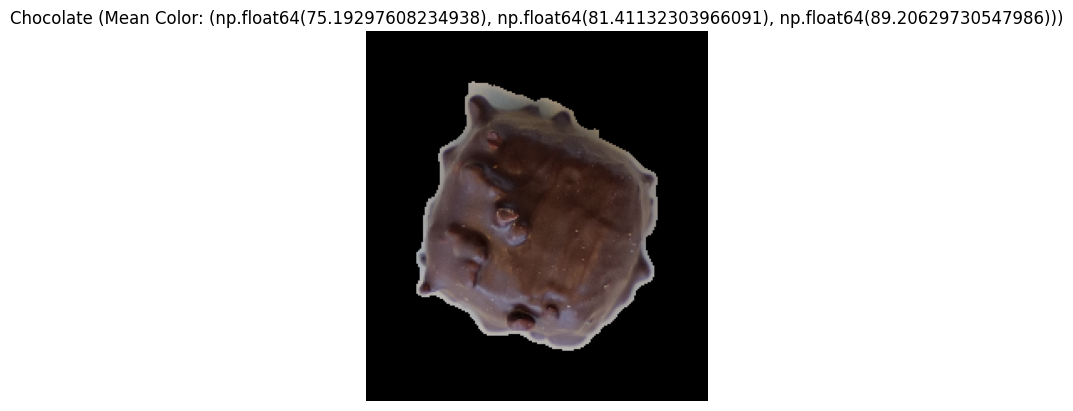

(np.float64(75.19297608234938), np.float64(81.41132303966091), np.float64(89.20629730547986))


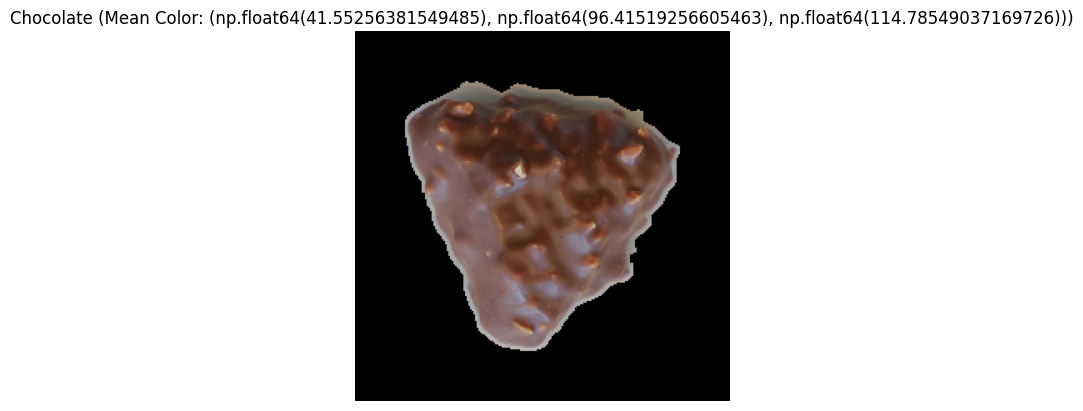

(np.float64(41.55256381549485), np.float64(96.41519256605463), np.float64(114.78549037169726))


In [ ]:
for img in reference_images:
    res, mean_color = segmentation(img)
    plot_choc(res, mean_color)